In [1]:
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import music21
import matplotlib as plt
import torchvision.utils as vutils

import torch.backends.cudnn as cudnn
torch.cuda.empty_cache()
cudnn.benchmark = True  # Optimise for hardware

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
BATCH_SIZE = 64
EPOCHS = 100
NOISE_DIM= 100
NUM_CLASSES = 18
BETA1 = 0.50 # Hyperparamter for adam optimizer
LRD = 0.0001 # Might need to adjust
LRG = 0.002
EMBEDDING_DIM = 50
MODEL_PATH = "Generator_model.pt"

In [3]:


import torch
import torch.nn as nn
 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Embedding for the labels
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBEDDING_DIM)  # (N, 50)

        # Dense layer for the label embedding
        self.fc_label = nn.Linear(EMBEDDING_DIM, 8 * 16)  # (N, 128)

        # Dense layer for the latent noise input
        self.fc_noise = nn.Linear(NOISE_DIM, 128 * 8 * 16)  # (N, 128 * 8 * 16)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1),  # Upsample to 16x32
            nn.BatchNorm2d(128), nn.ReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample to 32x64
            nn.BatchNorm2d(64), nn.ReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Upsample to 64x128
            nn.BatchNorm2d(32), nn.ReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)     # Upsample to 128x256
        )

        #self._initialize_weights()
        
    def forward(self, noise, labels):
       
        # Step 1: Embed the labels
        label_embedding = self.label_emb(labels)  # (N, EMBEDDING_DIM)
        
        label_embedding = self.fc_label(label_embedding)  # (N, 128)
    
        label_embedding = label_embedding.view(BATCH_SIZE, 8, 16, 1)  # Reshape to (N, 8, 16, 1)
        
        # Step 2: Process the latent noise input through a dense layer
        noise_embedding = self.fc_noise(noise)  # (N, 128 * 8 * 16)
        #noise_embedding = torch.relu(noise_embedding)  # Apply ReLU
        noise_embedding = noise_embedding.view(-1, 128, 8, 16)  # Reshape to (N, 128, 8, 16)

        # Step 3: Concatenate the noise and label embeddings along the channel axis
        x = torch.cat((noise_embedding, label_embedding.permute(0, 3, 1, 2)), dim=1)  # (N, 129, 8, 16)

        x = self.model(x)  # Apply the transposed convolutional layers

        # Step 9: Apply sigmoid activation to get output in range [0, 1]
        out = torch.sigmoid(x)  # Sigmoid activation for binary output

        return out  # Return the outp
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


# Instantiate the model
latent_dim = 100
num_classes = 18
model = Generator()

# Example input (noise and labels)
batch_size = 64
noise = torch.randn(batch_size, latent_dim)  # (N, latent_dim)
labels = torch.randint(0, num_classes, (batch_size,))  # (N,)

# Forward pass
output = model(noise, labels)
print(output.shape)  # Should be (batch_size, 1, 128, 256)




torch.Size([64, 1, 128, 256])


In [4]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_shape=(1, 128, 256), num_classes=NUM_CLASSES):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, EMBEDDING_DIM)

        # The output dimension after embedding will be the same as the input shape
        self.fc_label = nn.Linear(EMBEDDING_DIM, in_shape[1] * in_shape[2])

        # self.model = nn.Sequential(
        #     nn.Conv2d(2, 128, kernel_size=3, stride=2, padding=1),  # (2, 128, 256) -> (128, 64, 128)
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # (128, 64, 128) -> (128, 32, 64)
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),   # (128, 32, 64) -> (64, 16, 32)
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),    # (64, 16, 32) -> (64, 8, 16)
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),    # (64, 8, 16) -> (32, 4, 8)
        #     nn.BatchNorm2d(32),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(32, 1, kernel_size=3, stride=2, padding=1)      # (32, 4, 8) -> (1, 2, 4)
        # )
        
        self.model = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),  # (2, 128, 256) -> (128, 64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (128, 64, 128) -> (128, 32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # (128, 32, 64) -> (64, 16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),    # (64, 16, 32) -> (64, 8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),    # (64, 8, 16) -> (32, 4, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1)      # (32, 4, 8) -> (1, 2, 4)
        )
        #self._initialize_weights()
    def forward(self, pr, labels):
        # Step 1: Embed the labels
        label_embedding = self.label_emb(labels)
        label_embedding = self.fc_label(label_embedding)
        label_embedding = label_embedding.view(BATCH_SIZE, 1, 128, 256)  # Reshape to (N, 1, 128, 256)
        
        # Step 2: Concatenate image and label embeddings along the channel dimension
        x = torch.cat((pr, label_embedding), dim=1)  # Concatenate along channel dimension

        # Step 3: Pass through the model
        x = self.model(x)  # Apply the convolutional layers
        
        # Step 4: Average over height and width to get a single output
        out = torch.mean(x, dim=[2, 3])  # Global average pooling
        out = torch.sigmoid(out)  # Apply sigmoid activation for output

        return out  # Final output will be in range [0, 1]


    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
# Example of usage
discriminator = Discriminator(in_shape=(1, 128, 256), num_classes=10)

# Example inputs: random image and label
batch_size = 64
output = torch.randn(batch_size, 1, 128, 256)  # Random image input
labels = torch.randint(0, 10, (batch_size,))  # Random labels (10 classes)

# Forward pass
output1 = discriminator(output, labels)

print(output1.shape)  # Output should be (batch_size, 1)


torch.Size([64, 1])


In [5]:

from torch.utils.data import DataLoader, TensorDataset

inputs_seq = torch.load("Input_tensors.pt")
labels_seq = torch.load("Labels_tensors.pt")
dataset = TensorDataset(inputs_seq, labels_seq)

#Split into batches
batch_size = BATCH_SIZE
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check that the data is loaded correctly
print("Number of input pianorolls: ", len(dataset))
print("Length of dataloader: ", len(dataloader))


Number of input pianorolls:  1206
Length of dataloader:  19


C:\Users\skern\AppData\Local\Temp\ipykernel_5924\3286671830.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs_seq = torch.load("Input_tensors.pt")
C:\Users\skern\Ap

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Send the models to the GPU
netG = Generator().to(device)
netD = Discriminator().to(device)


criterion = nn.BCELoss()
# Initialize the labels
real_label = 0.90
fake_label = 0

fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM,  device=device)

# Define the optimizers
optimizerG = optim.Adam(netG.parameters(), lr=LRG, betas=(BETA1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=LRD, betas=(BETA1, 0.999))

netG.apply(weights_init)
netD.apply(weights_init)

print("Generator model: ", netG)
print("Discriminator model: ", netD)

Generator model:  Generator(
  (label_emb): Embedding(18, 50)
  (fc_label): Linear(in_features=50, out_features=128, bias=True)
  (fc_noise): Linear(in_features=100, out_features=16384, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(129, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Discriminator model:  Discriminator(
  (label_emb): Embedding(18, 50)
  (fc_label): 

In [8]:

# Lists to keep track of progress
output_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 30

""" 
This is the training loop for the model. To train GAN's, first train the discriminator on bacthes of the real data and then some fake outputs from the generator.
The loss of the discriminator will be the combvination of the real/fake output losses.

Train the Generator and caluclate the loss from its outputs.

"""

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        
        ##########
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        # Format batch
        real_cpu = data[0].to(device).float()   # ensure tensor is float32
        real_cpu = real_cpu.unsqueeze(1)
        
        b_size = real_cpu.size(0)
        
        if b_size != BATCH_SIZE:
            #print(f"Skipping batch {i} due to insufficient size: {b_size}")
            continue
        
        real_label_from_data = data[1].to(device).int()     # Generator and discriminator expect integer labels
        
    
        # Creates a label tensor of 1s to pass to loss function
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        netD.zero_grad()
        # Forward pass real batch through D
        output = netD(real_cpu, real_label_from_data).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NOISE_DIM, dtype=torch.float, device=device)

        # Generate fake image batch with G
        fake = netG(noise, real_label_from_data)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), real_label_from_data).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
    
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, real_label_from_data).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch,EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, real_label_from_data).detach().cpu()   # Move back to CPU so it can be used.
            
            output_list.append(fake)

        iters += 1

Starting Training Loop...
[0/100][0/19]	Loss_D: 1.4038	Loss_G: 1.3386	D(x): 0.4928	D(G(z)): 0.4871 / 0.3334
[0/100][5/19]	Loss_D: 1.4541	Loss_G: 0.8612	D(x): 0.3680	D(G(z)): 0.3388 / 0.4099
[0/100][10/19]	Loss_D: 1.3831	Loss_G: 0.9879	D(x): 0.4759	D(G(z)): 0.4687 / 0.3654
[0/100][15/19]	Loss_D: 1.5696	Loss_G: 1.0086	D(x): 0.4432	D(G(z)): 0.5239 / 0.3540
[1/100][0/19]	Loss_D: 1.5104	Loss_G: 0.9476	D(x): 0.4112	D(G(z)): 0.4619 / 0.3748
[1/100][5/19]	Loss_D: 1.4459	Loss_G: 0.9663	D(x): 0.4463	D(G(z)): 0.4782 / 0.3627
[1/100][10/19]	Loss_D: 1.3223	Loss_G: 0.8996	D(x): 0.4330	D(G(z)): 0.3955 / 0.3930
[1/100][15/19]	Loss_D: 1.4022	Loss_G: 1.0845	D(x): 0.5348	D(G(z)): 0.4823 / 0.3207
[2/100][0/19]	Loss_D: 1.3080	Loss_G: 1.2004	D(x): 0.5175	D(G(z)): 0.4434 / 0.3001
[2/100][5/19]	Loss_D: 1.3057	Loss_G: 0.9758	D(x): 0.4835	D(G(z)): 0.4349 / 0.3593
[2/100][10/19]	Loss_D: 1.2534	Loss_G: 0.9340	D(x): 0.4805	D(G(z)): 0.4069 / 0.3757
[2/100][15/19]	Loss_D: 1.1686	Loss_G: 0.9427	D(x): 0.5117	D(G(z)): 

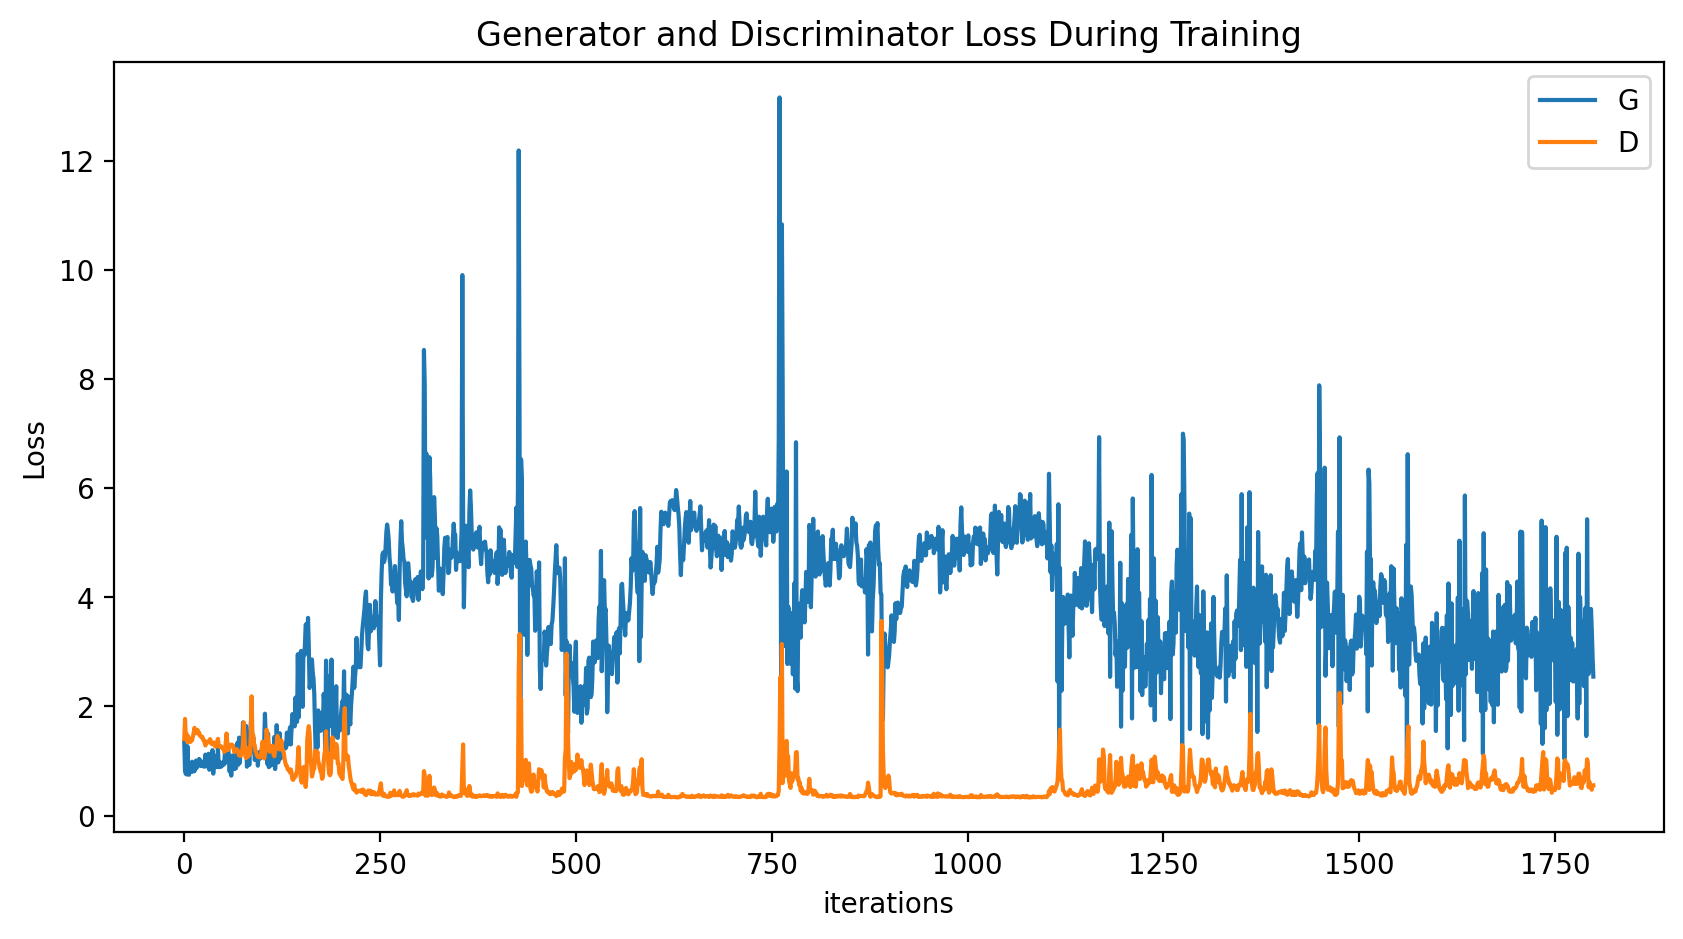

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

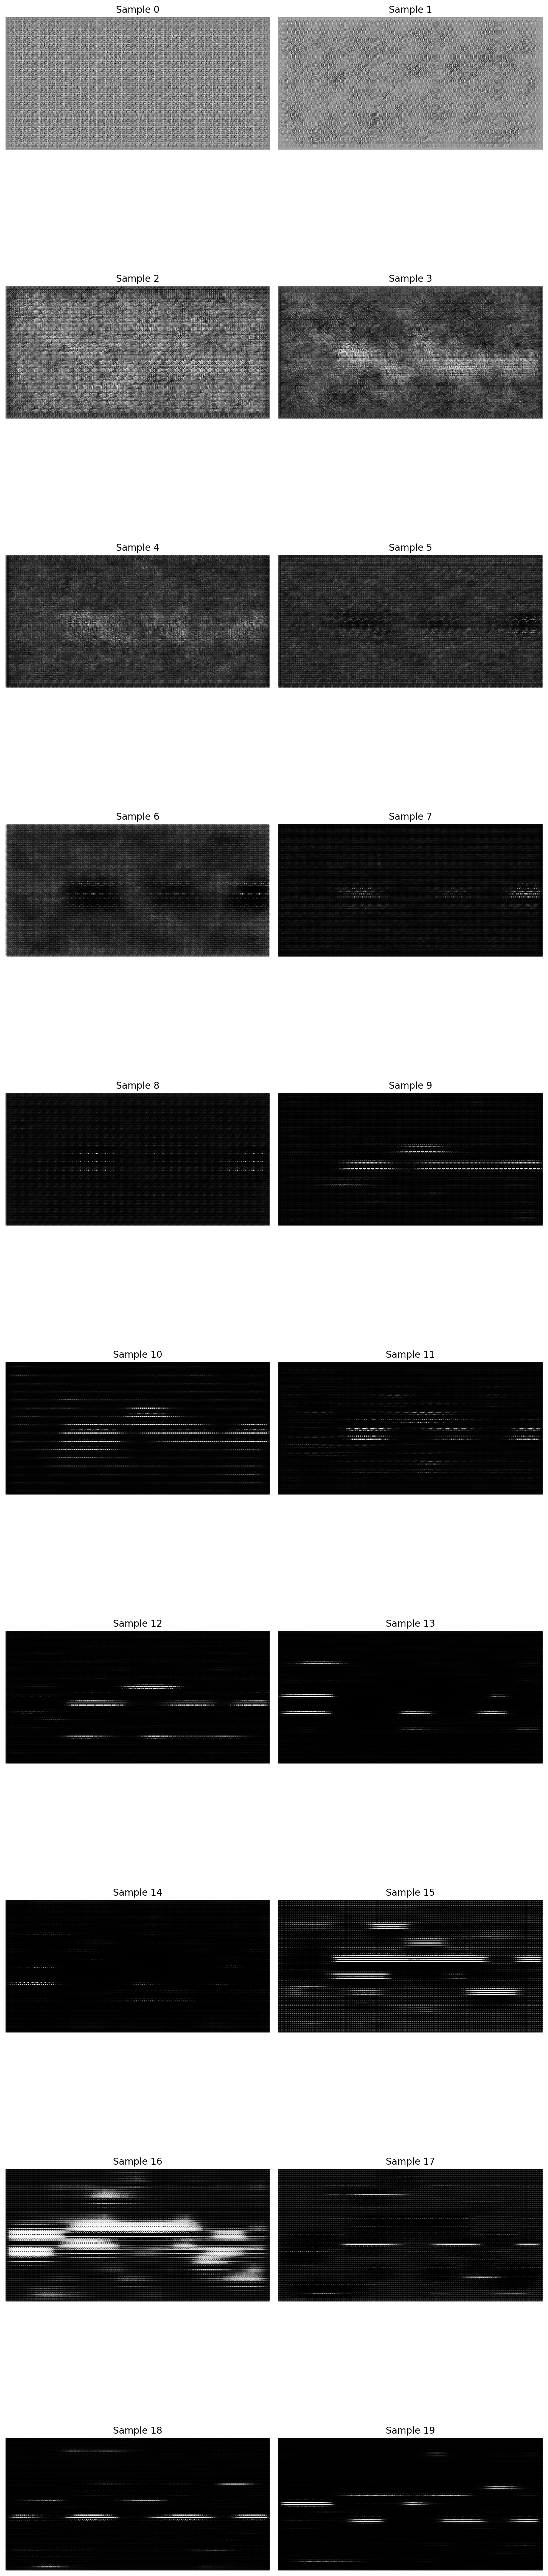

In [10]:
import matplotlib.pyplot as plt

# Set the number of samples to display
num_samples = 20
samples_per_row = 2
num_rows = num_samples // samples_per_row

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, samples_per_row, figsize=(10, num_rows * 5))

# Loop through the samples
for i in range(num_samples):
    
    
    # Visualize the generated sample
    sample = output_list[i][0][0].cpu()  # Remove batch dimension
    
    
    # Determine the current subplot position
    row = i // samples_per_row
    col = i % samples_per_row
    
    # Plot the sample
    axs[row, col].imshow(sample.detach().numpy(), cmap='gray')  # Use cmap='gray' for single-channel images
    axs[row, col].axis('off')  # Turn off axis
    axs[row, col].set_title(f'Sample {i}')  # Optional: add a title

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
# Print and save the model's state_dict
print("Model's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

torch.save(netG.state_dict(), MODEL_PATH)

Model's state_dict:
label_emb.weight 	 torch.Size([18, 50])
fc_label.weight 	 torch.Size([128, 50])
fc_label.bias 	 torch.Size([128])
fc_noise.weight 	 torch.Size([16384, 100])
fc_noise.bias 	 torch.Size([16384])
model.0.weight 	 torch.Size([129, 128, 4, 4])
model.0.bias 	 torch.Size([128])
model.1.weight 	 torch.Size([128])
model.1.bias 	 torch.Size([128])
model.1.running_mean 	 torch.Size([128])
model.1.running_var 	 torch.Size([128])
model.1.num_batches_tracked 	 torch.Size([])
model.3.weight 	 torch.Size([128, 64, 4, 4])
model.3.bias 	 torch.Size([64])
model.4.weight 	 torch.Size([64])
model.4.bias 	 torch.Size([64])
model.4.running_mean 	 torch.Size([64])
model.4.running_var 	 torch.Size([64])
model.4.num_batches_tracked 	 torch.Size([])
model.6.weight 	 torch.Size([64, 32, 4, 4])
model.6.bias 	 torch.Size([32])
model.7.weight 	 torch.Size([32])
model.7.bias 	 torch.Size([32])
model.7.running_mean 	 torch.Size([32])
model.7.running_var 	 torch.Size([32])
model.7.num_batches_tracke